In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scikitplot import metrics 
import inspect, re
import time
import timeit
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity= 'all'

In [2]:
######### Load input data from .csv file
tcc = pd.read_csv('ChurnData.csv')
tcc.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
######### Data preprocessing to format feature columns and get prediction target column 'labels'

category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
 

target = 'Churn'
ID_col = 'customerID'
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]


tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

In [4]:
######### Split input data into training dataset, and holdout testing dataset

X_train, X_test,y_train,y_test = train_test_split(features,labels, test_size=0.3, random_state=22)


######### Apply ordinal encoder to convert categorical values into numerical values 

ord_enc = OrdinalEncoder()
ord_enc.fit(X_train[category_cols])

X_train_OE = pd.DataFrame(ord_enc.transform(X_train[category_cols]), columns=category_cols)
X_train_OE.index = X_train.index
X_train_OE = pd.concat([X_train_OE, X_train[numeric_cols]], axis=1)

X_test_OE = pd.DataFrame(ord_enc.transform(X_test[category_cols]), columns=category_cols)
X_test_OE.index = X_test.index
X_test_OE = pd.concat([X_test_OE, X_test[numeric_cols]], axis=1)

OrdinalEncoder()

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
#Define the classifier.
odf_xgb = XGBClassifier(max_depth=3,
                        learning_rate=0.1,
                        n_estimators=100,
                        verbosity=1,
                        objective='binary:logistic',
                        booster='gbtree',
                        n_jobs=4,
                        gamma=0.001,
                        subsample=0.632,
                        colsample_bytree=1,
                        colsample_bylevel=1,
                        colsample_bynode=1,
                        reg_alpha=1,
                        reg_lambda=0,
                        scale_pos_weight=40,
                        base_score=0.5,
                        random_state=251162728,
                        missing=None
                        )
                      

In [7]:
odf_xgb.fit(X_train_OE,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=251162728, reg_alpha=1, reg_lambda=0,
              scale_pos_weight=40, subsample=0.632, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [8]:
import pickle

In [9]:
pickle.dump(odf_xgb, open('model.pkl', 'wb'))

In [11]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(X_test_OE)

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

Text(0.5, 1.0, 'Variable Importance - XGBoosting')

<AxesSubplot:title={'center':'Variable Importance - XGBoosting'}>

[Text(0, 0.5, 'Variable'), Text(0.5, 0, 'Variable Importance (Entropy)')]

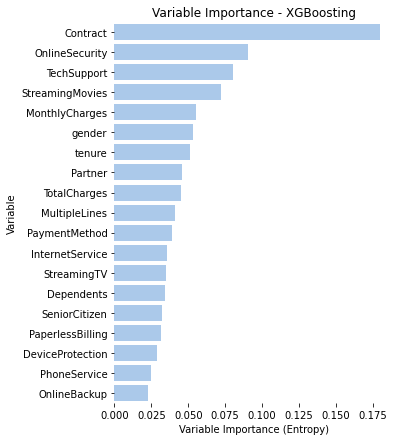

In [8]:
# plot features importance
importances = odf_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
f, ax = plt.subplots(figsize=(5, 7))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[X_train_OE.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

In [54]:
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix

In [136]:
X_test_OE

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
6187,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0,8,20.15,165.50
6448,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,58,104.65,6219.60
5492,0.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,65,25.30,1748.55
2028,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0,15,19.60,331.60
5376,1.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,18,23.75,424.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5983,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0,22,50.35,1098.85
3690,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,1.0,1.0,24,54.15,1240.25
855,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,1.0,2.0,62,100.15,6413.65
5187,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,1.0,2.0,41,104.40,4133.95


In [95]:
XGBClassTest 

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

[Text(0, 0.5, 'good'), Text(0, 1.5, 'bad')]

[Text(0.5, 0, 'good'), Text(1.5, 0, 'bad')]

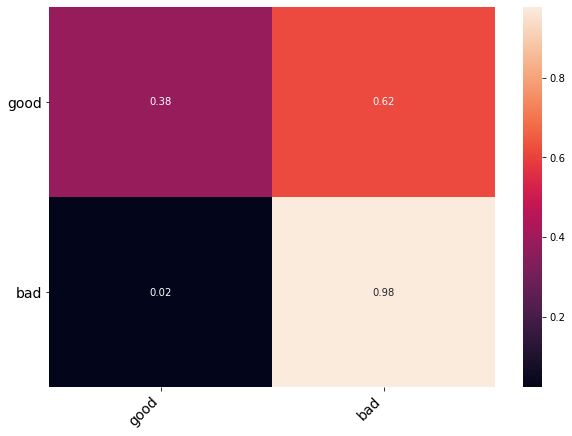

In [10]:
XGBClassTest = odf_xgb.predict(X_test_OE)
xg_probs_test0 = odf_xgb.predict_proba(X_test_OE)
xg_probs_test = xg_probs_test0[:, 1]


confusion_matrix_xgb = confusion_matrix(y_true = y_test, 
                    y_pred = XGBClassTest)


confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]


df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)


figsize = (10,7)
fontsize=14


fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')


heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

In [11]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

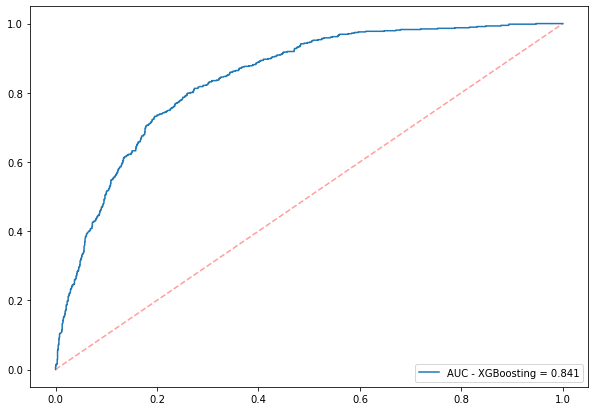

In [12]:
# Calculate the ROC curve points
fig = plt.figure(figsize=figsize)
fpr, tpr, thresholds = roc_curve(y_test, 
                                 xg_probs_test)


auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = xg_probs_test,average='macro'),
               decimals = 3)

plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)

In [13]:
######### class of XGBoost model with functions including:  
######### model fitting, Hyperparameter tuning, target variable prediction, and output performance plots

class XGBmodel(object):
    
    def __init__(self,param):
        self.param=param
        
    def fit(self, X, y):
        clf = xgb.XGBClassifier(random_state=22)
        clf_search=RandomizedSearchCV(estimator=clf,n_iter=50,param_distributions=self.param, scoring='accuracy',cv=10,n_jobs=4)
        clf_search.fit(X,y)
        self.clf = clf_search.best_estimator_
        return self
        
    def predict_proba(self, X):
        res_proba = self.clf.predict_proba(X)
        return res_proba
    
    def predict(self, X):
        res = self.clf.predict(X)
        return res
    def show_test_result(self,X,y):
        result_proba=self.predict_proba(X)
        result_=self.predict(X)
        metrics.plot_roc(y,result_proba)
        predictions = cross_val_predict(self.clf, X, y)
        plot = metrics.plot_confusion_matrix(y, predictions, normalize=True)
        
        
    def precision_recall_f1_visual(self,X,y):
        print(classification_report(y,self.predict(X),digits=4))

In [282]:
import scikitplot as skplt

In [305]:
import io

In [62]:
######### In order to find the best set of hyperparameter, 
######### xgboost model would try different combination of parameter values from user input lists,
######### and then return the model with best accuracy 

xgb_param = dict(learning_rate=[0.01, 0.016, 0.027, 0.046, 0.077, 0.129, 0.215, 0.359],
                     max_depth=[5, 10, 15],
                     n_estimators=[ 50,  70,  90, 110, 130, 150],
                     colsample_bytree=[0.4,  0.6,  0.8]
                     )

start = timeit.default_timer()
xgb_model= XGBmodel(xgb_param)
xgb_model.fit(X_train_OE,y_train)
stop = timeit.default_timer()
print('using Time:{:.2f} s'.format(stop - start))
xgb_model.precision_recall_f1_visual(X_test_OE,y_test)

using Time:69.31 s
              precision    recall  f1-score   support

           0     0.8279    0.8922    0.8588      1531
           1     0.6436    0.5120    0.5703       582

    accuracy                         0.7875      2113
   macro avg     0.7358    0.7021    0.7146      2113
weighted avg     0.7771    0.7875    0.7794      2113



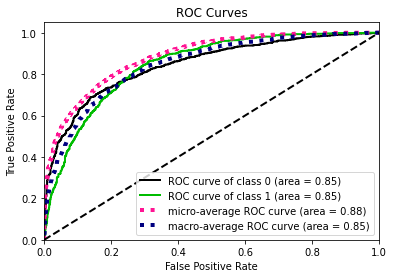

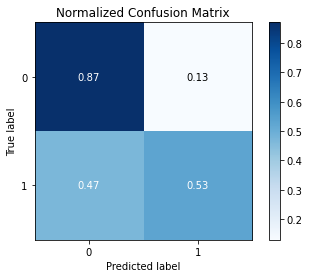

In [15]:
######### Show model ROC CURV and 
xgb_model.show_test_result(X_test_OE,y_test)